# EDA

본 EDA의 주요 목적은 다음과 같습니다.

훈련 및 추론용 하이퍼파라미터의 설정 근거 마련

모델링 과정에서의 주요 인사이트 획득

텍스트 정제 코드 구현.

# Get Tokenizer

In [7]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v1')
tokenizer

PreTrainedTokenizerFast(name_or_path='gogamza/kobart-base-v1', vocab_size=30000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'})

# Encode and Calculate Lines

전체 훈련용 데이터 세트에 대해 토크나이징을 진행한 뒤, 입출력간 상관관계를 확인하는 절차를 수행함으로써 

max_input_len(원문 문장의 최대 길이) 및 max_tar_len(타겟 문장의 최대 길이)의 적절한 값을 설정. 

본 과정은 데이콘 대회 규칙 및 AI Hub의 구축 가이드라인에 명시되어 있는, 전체 문장의 10~20% 내외로 요약문을 구축하였음을 검증하는 과정.


이미지를 확인해 보았을 때, 데이콘의 주장과는 다르게 도메인이 직선 y=0.1x 에 적합(fitting)하지는 않는 것으로 보이며, max_inp_len=1024, max_tar_len=256으로 설정하는데에 무리가 없다고 판단


In [44]:
# make index list
from tqdm import tqdm
import os
import numpy as np
import json
import pandas as pd
import re

json_data=[]
psg_tsv = [] # 원본
psg_tsv_str=[]
smy_tsv = [] # 요약
smy_tsv_str=[]

def listToString(str_list):
    result = ""
    for s in str_list:
        result += s + " "
    return result.strip()

with open('./data/test_news.jsonl') as f:
    for line in tqdm(f):
        # line은 String 값 
        json_data.append(json.loads(line)) # 전체데이터 딕셔너리 형태로 넣기 

    num = 0
    for json_num_list in tqdm(json_data):
        psg_tsv.append(json_data[num]['article_original']) # 데이터 원문입니다.
        psg_tsv_str.append(listToString(psg_tsv[num]))
       

        smy_tsv.append(json_data[num]['abstractive'])
     
    
        num+=1


30122it [00:00, 30971.56it/s]
100%|██████████| 30122/30122 [00:00<00:00, 179297.89it/s]


In [45]:
print(psg_tsv_str[0])

[ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 "넓고, 체증 없는 '통신 고속도로'가 5G"라며 "대한민국의 대전환이 이제 막 시작됐다"고 기대감을 높였다. 문 대통령은 8일 서울 올림픽공원에서 열린 5G플러스 전략발표에 참석해 "5G 시대는 우리가 생각하고, 만들면 그것이 세계 표준이 되는 시대"라며 "5G는 대한민국 혁신성장의 인프라"라고 강조했다. 산업화 시대에 고속도로가 우리 경제의 '대동맥' 역할을 했듯, 5G가 4차 산업혁명 시대의 고속도로가 돼 새로운 기회를 열어 줄 것이란 설명이다. 문 대통령은 "5G가 각 분야에 융합되면, 정보통신산업을 넘어 자동차, 드론(무인항공기), 로봇, 지능형 폐쇄회로TV(CCTV)를 비롯한 제조업과 벤처에 이르기까지 우리 산업 전체의 혁신을 통한 동반성장이 가능하다"고 밝혔다. 세계 최초 상용화에 성공한 5G가 반도체를 이을 우리 경제의 새 먹거리가 될 것이란 관측이다. 정부는 2026년 세계 5G 시장 규모가 1161조원에 달할 것으로 보고 있다. 작년 반도체 시장 규모가 529조원인 점을 고려하면 2배 이상 큰 미래 시장이 창출되는 셈이다. 문 대통령은 아직은 국민에게 다소 낯선 5G 시대의 미래상을 친절히 설명해 눈길을 끌기도 했다. 문 대통령은 "'지금 스마트폰으로 충분한데, 5G가 왜 필요하지?'라고 생각할 수 있다"며 "4세대 이동통신은 '아직은' 빠르지만 가까운 미래에는 결코 빠르지 않다"고 했다. 그러면서 "자동차가 많아질수록 더 넓은 길이 필요한 것처럼 사물과 사물을 연결하고, 데이터를 주고받는 이동통신망도 더 넓고 빠른 길이 필요하다"고 덧붙였다. 문 대통령은 세계 최초 상용화에 성공한 우리 5G 기술을 널리 알리는 홍보대사를 자처하기도 했다. 5G 시장을 선점하기 위한 각국의 경쟁이 뜨겁게 달아오른 만큼 정부 차원에서 적극 지원하겠다는 방침이다. 문 대통령은 "평창동계올림픽 360도 중계, 작년 4·27 남북한 정상회담 때 프레스센터에서 사용된 스마트월처럼 기회가 생기면 대

In [46]:
test_labeling = pd.concat([pd.DataFrame(psg_tsv_str),pd.DataFrame(smy_tsv)], axis = 1)
test_labeling.columns = ['passage' ,'summary'] # 뉴스 학습데이터 양식 맞추기 (원문  요약문 => 탭 구분)

df = test_labeling
df

,passage,summary
0,"[ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 ""넓고, 체...",8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁...
1,] 당 지도부 퇴진을 놓고 바른미래당 내홍이 격화되고 있다. 바른미래당이 8일 연 ...,8일 바른미래당 최고의원 회의에 하태경 의원 등 5명의 최고의원이 지도부 퇴진을 요...
2,[ 홍윤정 기자 ] 8일 서울 올림픽공원 K아트홀. 지난 3일 한국이 세계 최초로 ...,지난 3일 한국이 세계 첫 5세대 이동통신 서비스를 보편화한 것을 축하하는 '코리안...
3,] 박원순 서울시장(사진)이 8일 고층 재개발·재건축 관련 요구에 작심한 듯 쓴소리...,박원순 서울시장은 8일 서울시청에서 열린 '골목길 재생 시민 정책 대화'에 참석하여...
4,"[ 임근호 기자 ] ""SK(주)와 미국 알파벳(구글 지주회사)의 간결한 지배구조를 ...",주주가치 포커스를 운용하는 KB자산운용이 SK와 알파벳(구글 지주회사)의 모범적 ...
...,...,...
30117,영주시는 이억만리에서 건너온 계절근로자들의 향수를 달래고 안정된 한국생활 적응을 돕...,"영주시는 외국인 근로자들의 향수를 달래고, 안정적인 한국생활 적응을 지원하기 위해 ..."
30118,여름 방학을 맞아 전국의 국립과학관에서 달 탐사 50주년과 국제천문연맹(IAU) 설...,달 탐사 50주년과 국제천문연맹(IAU)설립 100주년 기념하는 특별전시가 전국의 ...
30119,영주문경예천 당원협의회 시국강연 및 당원교육에 참석차 영주를 방문한 황교안(오른쪽)...,황교안 대표는 지난 29일 자유한국당 대표로 경북 영주문경예청 당원협의회 당원교육에...
30120,경북예천군은 장기적인 국내 경기침체가 지속됨에 따라 사회적경제 기업 육성 등을 통한...,경북예천군은 사회적경제 기업 육성 등을 통한 일자리 창출에 행정동력을 집중한 결과 ...


In [47]:
#데이터프레임을 리스트로 변환 
passage_df = df['passage'].values.tolist()
summary_df = df['summary'].values.tolist()
print(len(passage_df[0]))
print(passage_df[0])
print(summary_df[0])

1032
[ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 "넓고, 체증 없는 '통신 고속도로'가 5G"라며 "대한민국의 대전환이 이제 막 시작됐다"고 기대감을 높였다. 문 대통령은 8일 서울 올림픽공원에서 열린 5G플러스 전략발표에 참석해 "5G 시대는 우리가 생각하고, 만들면 그것이 세계 표준이 되는 시대"라며 "5G는 대한민국 혁신성장의 인프라"라고 강조했다. 산업화 시대에 고속도로가 우리 경제의 '대동맥' 역할을 했듯, 5G가 4차 산업혁명 시대의 고속도로가 돼 새로운 기회를 열어 줄 것이란 설명이다. 문 대통령은 "5G가 각 분야에 융합되면, 정보통신산업을 넘어 자동차, 드론(무인항공기), 로봇, 지능형 폐쇄회로TV(CCTV)를 비롯한 제조업과 벤처에 이르기까지 우리 산업 전체의 혁신을 통한 동반성장이 가능하다"고 밝혔다. 세계 최초 상용화에 성공한 5G가 반도체를 이을 우리 경제의 새 먹거리가 될 것이란 관측이다. 정부는 2026년 세계 5G 시장 규모가 1161조원에 달할 것으로 보고 있다. 작년 반도체 시장 규모가 529조원인 점을 고려하면 2배 이상 큰 미래 시장이 창출되는 셈이다. 문 대통령은 아직은 국민에게 다소 낯선 5G 시대의 미래상을 친절히 설명해 눈길을 끌기도 했다. 문 대통령은 "'지금 스마트폰으로 충분한데, 5G가 왜 필요하지?'라고 생각할 수 있다"며 "4세대 이동통신은 '아직은' 빠르지만 가까운 미래에는 결코 빠르지 않다"고 했다. 그러면서 "자동차가 많아질수록 더 넓은 길이 필요한 것처럼 사물과 사물을 연결하고, 데이터를 주고받는 이동통신망도 더 넓고 빠른 길이 필요하다"고 덧붙였다. 문 대통령은 세계 최초 상용화에 성공한 우리 5G 기술을 널리 알리는 홍보대사를 자처하기도 했다. 5G 시장을 선점하기 위한 각국의 경쟁이 뜨겁게 달아오른 만큼 정부 차원에서 적극 지원하겠다는 방침이다. 문 대통령은 "평창동계올림픽 360도 중계, 작년 4·27 남북한 정상회담 때 프레스센터에서 사용된 스마트월처럼 기회가 

In [48]:
df.to_csv('./data/test_news.tsv', index=False, sep="\t", encoding="utf-8") # sep활용하여 tab 구분 정의 

TSV파일 합치기

In [55]:
import pandas as pd

# 열려는 파일이 tsv 파일인 경우
test_tsv1 = pd.read_csv('./data/train_news.tsv', sep = '\t')
test_tsv2 = pd.read_csv('./data/train_editorial.tsv', sep = '\t')
#test_tsv1
#test_tsv2

sum_test = pd.concat([test_tsv1, test_tsv2], axis = 0, sort=False)
sum_test

,passage,summary
0,ha당 조사료 400만원…작물별 차등 지원 이성훈 sinawi@hanmail.net...,전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...
1,"8억 투입, 고소천사벽화·자산마을에 색채 입혀 이성훈 sinawi@hanmail.n...",여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...
2,전남드래곤즈 해맞이 다짐…선수 영입 활발 이성훈 sinawi@hanmail.net ...,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...
3,"11~24일, 매실·감·참다래 등 지역특화작목 이성훈 sinawi@hanmail.n...","광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특화작..."
4,"홍콩 크루즈선사‘아쿠아리우스’ 4, 6월 여수항 입항 이성훈 sinawi@hanma...",올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항...
...,...,...
56755,판문점 북·미 정상회담은 교착상태에 빠졌던 양측의 비핵화 협상을 단박에 대화 국면으...,북미 관계는 정상궤도에 올랐으나 남북 관계는 지지부진하기 때문에 빠른 시일에 남북 ...
56756,"참의원 선거 앞둔 아베, 노림수 담긴 위험한 선택… 전략에 말려들지 않으려면 교역 ...",아베 일본 정부는 일본 강제징용 피해자에게 배상해야 한다는 우리 법원의 판결로 일본...
56757,미쓰비시중공업 정기 주총이 열린 27 일 오전 이 회사 본사가 있는 도쿄 마루노우치...,일본 경제산업성이 4일부터 수출 관리 규정을 개정해 스마트폰 및 TV에 사용되는 반...
56758,지난달 17 일 학교 비정규직 노동자들이 청와대 앞에서 처우개선 등을 요구하며 시위...,지난달 17일 학교 비정규직 노동자들이 청와대 앞에서 처우개선을 요구하는 시위를 진...


In [54]:
sum_test.to_csv('./data/train.tsv', index=False, sep="\t") # sep활용하여 tab 구분 정의

# EDA (뉴스, 사설 전체 데이터 학습)

# Import Data

In [73]:
import numpy as np
from tqdm import tqdm # 반복 루프를 돌면서 얼마나 진행되었는지 progress bar로 표현해주는 것

#texts = [document["article_original"] for document in json_data]
#summaries = [document["abstractive"] for document in json_data]

texts = passage_df
summaries = summary_df

len_text = []
len_summary = []

for text, summary in tqdm(zip(texts, summaries), total=len(texts)):
    len_text.append(len(tokenizer.encode(text)))
    len_summary.append(len(tokenizer.encode(summary)))

len_text = np.array(len_text)
len_summary = np.array(len_summary)

100%|██████████| 20000/20000 [00:21<00:00, 933.25it/s] 


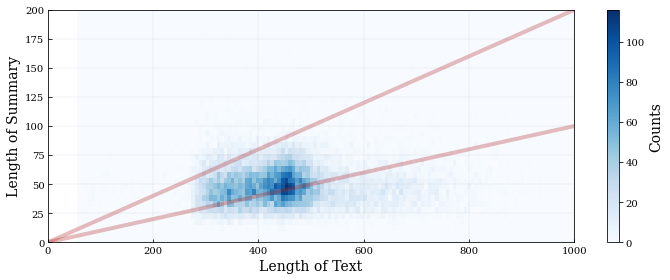

In [74]:
from matplotlib import pyplot as plt
from matplotlib import colors

## Show relations.
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(10, 4), facecolor="white", dpi=72)

x = len_text
y = len_summary

x_bins = np.linspace(min(x), max(x), 140)
y_bins = np.linspace(min(y), max(y), 50)

# matplotlib.colors.LogNorm()
plt.hist2d(x, y, bins=[x_bins, y_bins], cmap="Blues", norm=None)
cbar = plt.colorbar()
cbar.set_label("Counts", fontsize=14)

## y = 0.1 * x or (0.2)
foo = np.linspace(0, max(x), 1000)
bar = foo * 0.2
bar1 = foo * 0.1
plt.plot(foo, bar, lw=4, c="firebrick", alpha=.3)
plt.plot(foo, bar1, lw=4, c="firebrick", alpha=.3)

plt.xlim([0, 1000])
plt.ylim([0, 200])
plt.xlabel("Length of Text", fontsize=14)
plt.ylabel("Length of Summary", fontsize=14)

ax.tick_params(axis="both", direction="in")

plt.grid(True, lw=0.15)

plt.tight_layout()
# plt.savefig("2.png", dpi=300)
plt.show()